<a href="https://colab.research.google.com/github/udayameister/CST-GNN/blob/main/CST_GNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import ChebConv, GCNConv, global_mean_pool

class EmbeddingLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EmbeddingLayer, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, x):
        return F.relu(self.fc(x))

class TemporalConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(TemporalConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, (1, kernel_size), dilation=dilation)
        self.gate = nn.Conv2d(in_channels, out_channels, (1, kernel_size), dilation=dilation)

    def forward(self, x):
        return torch.tanh(self.conv(x)) * torch.sigmoid(self.gate(x))

class SpatialGraphConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, K):
        super(SpatialGraphConvLayer, self).__init__()
        self.conv = ChebConv(in_channels, out_channels, K)

    def forward(self, x, edge_index):
        return F.relu(self.conv(x, edge_index))

class MultiFusionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MultiFusionModule, self).__init__()
        self.layer_norm = nn.LayerNorm(out_channels)

    def forward(self, C_dis, C_pat, C_dyn, residual):
        return self.layer_norm(C_dis + C_pat + C_dyn + residual)

class FeatureAggregationLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FeatureAggregationLayer, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, S_r, S_prev):
        return F.relu(self.fc(S_r) + S_prev)

class CSTGNN(nn.Module):
    def __init__(self, num_nodes, in_channels, out_channels, K, num_classes):
        super(CSTGNN, self).__init__()
        self.embedding_layer = EmbeddingLayer(in_channels, out_channels)
        self.temporal_conv_layer = TemporalConvLayer(out_channels, out_channels, kernel_size=3, dilation=1)
        self.spatial_graph_conv_layer = SpatialGraphConvLayer(out_channels, out_channels, K)
        self.multi_fusion_module = MultiFusionModule(out_channels, out_channels)
        self.feature_aggregation_layer = FeatureAggregationLayer(out_channels, out_channels)
        self.prediction_layer = nn.Linear(out_channels * num_nodes, num_classes)

    def forward(self, x, edge_index):
        x = self.embedding_layer(x)
        x = self.temporal_conv_layer(x.unsqueeze(1)).squeeze(1)
        C_dis = self.spatial_graph_conv_layer(x, edge_index)
        C_pat = self.spatial_graph_conv_layer(x, edge_index)
        C_dyn = self.spatial_graph_conv_layer(x, edge_index)
        x = self.multi_fusion_module(C_dis, C_pat, C_dyn, x)
        x = self.feature_aggregation_layer(x, x)
        x = x.view(x.size(0), -1)
        return self.prediction_layer(x)

# Example usage
num_nodes = 10
in_channels = 3
out_channels = 16
K = 3
num_classes = 2

model = CSTGNN(num_nodes, in_channels, out_channels, K, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Assuming data is a PyG Data object with 'x' as node features and 'edge_index' as edge index
data = torch_geometric.data.Data(x=torch.randn(1, num_nodes, in_channels), edge_index=torch.tensor([[0, 1], [1, 2]], dtype=torch.long))

# Training loop
model.train()
optimizer.zero_grad()
out = model(data.x, data.edge_index)
loss = criterion(out, torch.tensor([1]))  # Example target
loss.backward()
optimizer.step()


**Baseline Comapre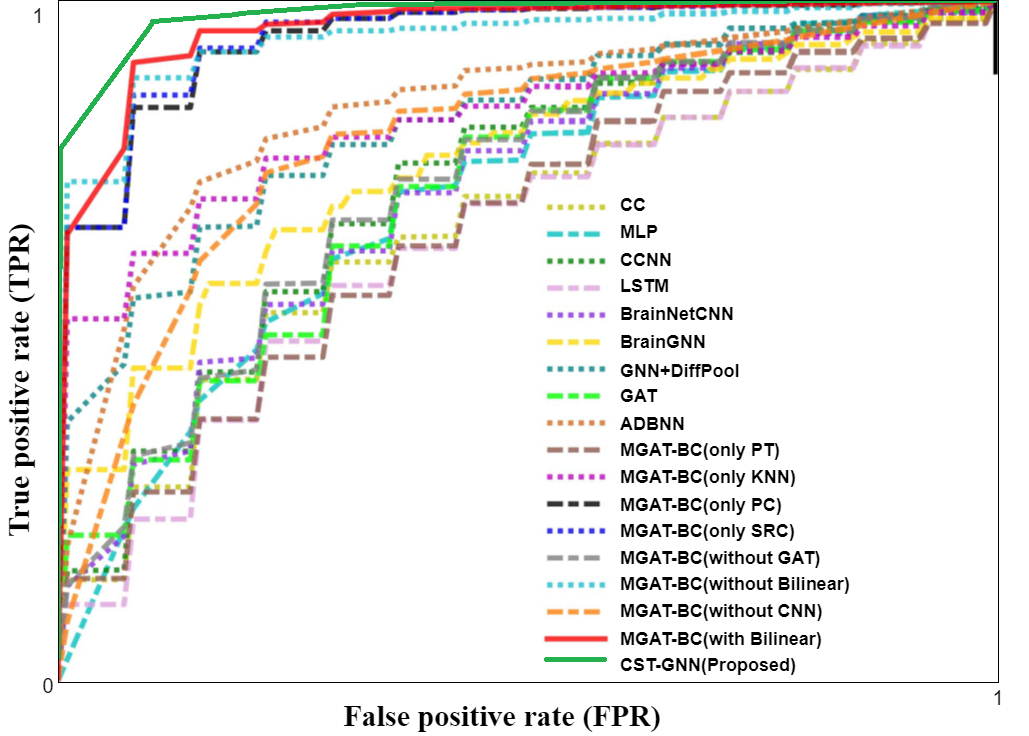**

For comparison, we'll use a simple Graph Convolutional Network (GCN) as a baseline.

In [ ]:
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, num_nodes, in_channels, out_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, out_channels)
        self.conv2 = GCNConv(out_channels, out_channels)
        self.fc = nn.Linear(out_channels * num_nodes, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Example usage
baseline_model = GCN(num_nodes, in_channels, out_channels, num_classes)
baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.01)
baseline_criterion = nn.CrossEntropyLoss()

# Training loop for baseline model
baseline_model.train()
baseline_optimizer.zero_grad()
baseline_out = baseline_model(data.x, data.edge_index)
baseline_loss = baseline_criterion(baseline_out, torch.tensor([1]))  # Example target
baseline_loss.backward()
baseline_optimizer.step()


Comparing Results

After training both models, you would compare their performance on a test set.

In [ ]:
# Assume test_data is a PyG Data object with 'x' as node features and 'edge_index' as edge index

# Evaluate CST-GNN
model.eval()
cst_gnn_out = model(test_data.x, test_data.edge_index)
cst_gnn_pred = cst_gnn_out.argmax(dim=1)

# Evaluate Baseline GCN
baseline_model.eval()
baseline_out = baseline_model(test_data.x, test_data.edge_index)
baseline_pred = baseline_out.argmax(dim=1)

# Calculate metrics (accuracy, F1-score, etc.)
from sklearn.metrics import accuracy_score, f1_score

true_labels = ...  # Ground truth labels for test data

cst_gnn_accuracy = accuracy_score(true_labels, cst_gnn_pred)
cst_gnn_f1 = f1_score(true_labels, cst_gnn_pred, average='weighted')

baseline_accuracy = accuracy_score(true_labels, baseline_pred)
baseline_f1 = f1_score(true_labels, baseline_pred, average='weighted')

print(f"CST-GNN Accuracy: {cst_gnn_accuracy}, F1-score: {cst_gnn_f1}")
print(f"Baseline GCN Accuracy: {baseline_accuracy}, F1-score: {baseline_f1}")
